In [1]:
#Install what is needed
!pip install pandas numpy matplotlib xarray hvplot
!pip install rasterio
!pip install rioxarray
!pip install fiona 
!pip install geopandas
!pip install cartopy
!pip install geopandas geoviews
!pip install netCDF4
!pip install pydap
!pip install pygbif
!pip install osmnx
!pip install earthaccess
!pip install scikit-fuzzy

#Import from installations
import fiona
import os
import pathlib
import hvplot.xarray  
import rioxarray  
import pathlib
import requests
import zipfile
import geopandas as gpd 
import hvplot.pandas
import netCDF4
import earthaccess
import skfuzzy


import xarray as xr
import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrsp
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from math import floor, ceil
from shapely.geometry import box
from rioxarray.merge import merge_arrays
from osmnx import features as osm
from pygbif import occurrences
from glob import glob
from rioxarray.merge import merge_arrays
from shapely.geometry import Point
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from pathlib import Path

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 33.0 MB/s eta 0:00:00


In [2]:
# save records into the iplant user
iplant_user = os.environ['IPLANT_USER']
data_path = (
    pathlib.Path.home()
    / 'data-store' / 'home' / iplant_user / 'habitat_suitability')

data_path.mkdir(parents = True, exist_ok = True)

data_path

# Define and create the project data directory
habitat_suitability_data_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'habitat_suitability'
)
os.makedirs(habitat_suitability_data_dir, exist_ok=True)

# Call the data directory to check its location
habitat_suitability_data_dir


# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Define correct project directory path
project_data_dir = os.path.join(
    pathlib.Path.home(),
    'Rocky_Mountain_Juniper_Study',
    'data',
    'habitat_suitability'
)
os.makedirs(project_data_dir, exist_ok=True)

print("Data directory is:", project_data_dir)

# Define WKT bounding box for ROMO area
bbox = "POLYGON((-105.9 40.1, -105.4 40.1, -105.4 40.6, -105.9 40.6, -105.9 40.1))"

# Query GBIF for Juniperus scopulorum
records = occurrences.search(
    scientificName="Juniperus scopulorum",
    hasCoordinate=True,
    limit=1000,
    geometry=bbox
)

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Search Juniperus scopulorum within bounding box (ROMO)
forest_gdf = osm.features_from_place(
    query = 'Roosevelt National Forest',
    tags = {'name':'Roosevelt National Forest'})

# ---------------------------------------------------------------------------------------------------------------------------------------------------
forest_gdf = forest_gdf.iloc[[0]]

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Convert GBIF records to DataFrame
juniper_gdf = gpd.read_file ('Juniper_Occur.zip')

juniper_gdf.eventDate = pd.to_datetime(juniper_gdf.eventDate , format='ISO8601', utc=True)

# Drop rows without lat/lon
juniper_gdf = juniper_gdf.dropna(subset=["decimalLatitude", "decimalLongitude","eventDate"])

juniper_gdf = (
    gpd.GeoDataFrame(
        juniper_gdf, 
        geometry=gpd.points_from_xy(
            juniper_gdf.decimalLongitude, 
            juniper_gdf.decimalLatitude), 
        crs="EPSG:4326")
    # Select the desired columns
    [['eventDate','geometry']]
)

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Ensure both are in EPSG:4326 for web maps
forest_gdf = forest_gdf.to_crs("EPSG:4326")
juniper_gdf = juniper_gdf.to_crs("EPSG:4326")

juniper_occur_gdf = juniper_gdf.sjoin(
    gpd.GeoDataFrame(
        geometry = forest_gdf.envelope),
    predicate = 'within')

Data directory is: /home/jovyan/Rocky_Mountain_Juniper_Study/data/habitat_suitability


In [3]:
# Load & squeeze
hist_suit = rxr.open_rasterio("hist_suit.tif").squeeze()
clay   = rxr.open_rasterio("clay_suitability.tif").squeeze()
sand   = rxr.open_rasterio("sand_suitability.tif").squeeze()
ph     = rxr.open_rasterio("ph_suitability.tif").squeeze()
elev   = rxr.open_rasterio("elev_suitability.tif").squeeze()

if not hist_suit.rio.crs:
    hist_suit = hist_suit.rio.write_crs("EPSG:4326")
    
#  Reproject to match precip
clay = clay.rio.reproject_match(hist_suit)
sand = sand.rio.reproject_match(hist_suit)
ph   = ph.rio.reproject_match(hist_suit)
elev = elev.rio.reproject_match(hist_suit)

# Ensure binary and combine
combined_hist = (hist_suit * clay * sand * ph * elev).astype("uint8")

# Save to GeoTIFF
combined_hist.name = "juniper_combined_suitability_hist"
combined_hist.rio.to_raster("juniper_suitability_combined_hist.tif")

print("Combined suitability saved as juniper_suitability_combined_hist.tif")

Combined suitability saved as juniper_suitability_combined_hist.tif


In [4]:
# Load & squeeze
fut_suit = rxr.open_rasterio("fut_suit.tif").squeeze()
clay   = rxr.open_rasterio("clay_suitability.tif").squeeze()
sand   = rxr.open_rasterio("sand_suitability.tif").squeeze()
ph     = rxr.open_rasterio("ph_suitability.tif").squeeze()
elev   = rxr.open_rasterio("elev_suitability.tif").squeeze()

if not fut_suit.rio.crs:
    fut_suit = fut_suit.rio.write_crs("EPSG:4326")
    
#  Reproject to match precip
clay = clay.rio.reproject_match(fut_suit)
sand = sand.rio.reproject_match(fut_suit)
ph   = ph.rio.reproject_match(fut_suit)
elev = elev.rio.reproject_match(fut_suit)

# Ensure binary and combine
combined_future = (fut_suit *clay * sand * ph *elev).astype("uint8")

# Save to GeoTIFF
combined_future.name = "juniper_combined_suitability_future"
combined_future.rio.to_raster("juniper_suitability_combined_future.tif")

print("Combined suitability saved as juniper_suitability_combined_future.tif")

Combined suitability saved as juniper_suitability_combined_future.tif


In [5]:
if juniper_occur_gdf.crs != combined_hist.rio.crs:
    juniper_occur_gdf = juniper_occur_gdf.to_crs(combined_hist.rio.crs)

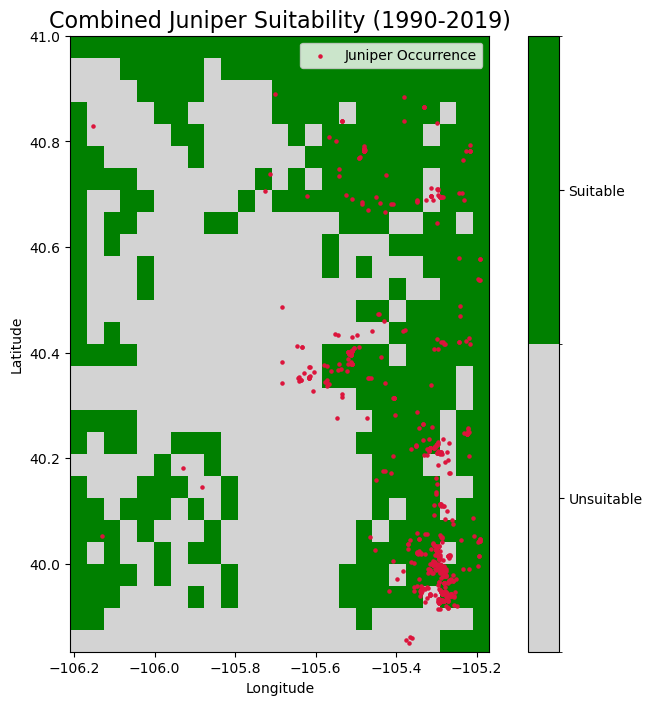

In [6]:
# Load combined suitability raster
combined_hist = rxr.open_rasterio("juniper_suitability_combined_hist.tif").squeeze()

# Define binary colormap (0 = Unsuitable, 1 = Suitable)
cmap = mcolors.ListedColormap(['lightgray', 'green'])
norm = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)

# Plot 
fig, ax = plt.subplots(figsize=(10, 8))
im = combined_hist.plot.imshow(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False
)

# add occurrence points
juniper_occur_gdf.plot(ax=ax, color='crimson', markersize=5, label='Juniper Occurrence')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['Unsuitable', 'Suitable'])

# Labels and formatting
ax.set_title("Combined Juniper Suitability (1990-2019)", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.tight_layout

plt.savefig("juniper_comb_hist_suitability.png", dpi=300, bbox_inches='tight')

plt.show()

In [7]:
if juniper_occur_gdf.crs != combined_future.rio.crs:
    juniper_occur_gdf = juniper_occur_gdf.to_crs(combined_future.rio.crs)

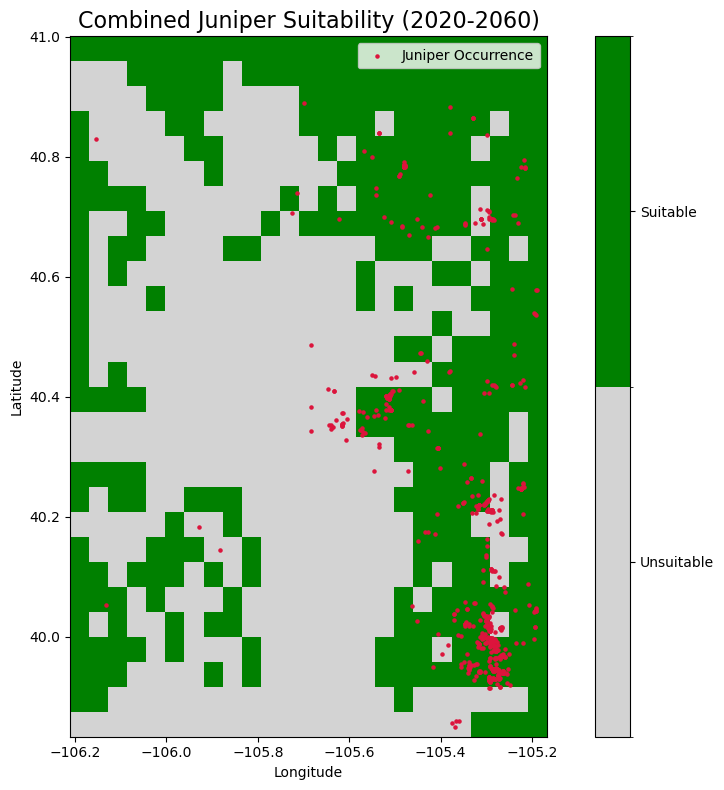

In [8]:
# Load combined suitability raster
combined_future = rxr.open_rasterio("juniper_suitability_combined_future.tif").squeeze()

# Define binary colormap (0 = Unsuitable, 1 = Suitable)
cmap = mcolors.ListedColormap(['lightgray', 'green'])
norm = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)

# Plot 
fig, ax = plt.subplots(figsize=(10, 8))
im = combined_future.plot.imshow(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False
)

# add occurrence points
juniper_occur_gdf.plot(ax=ax, color='crimson', markersize=5, label='Juniper Occurrence')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['Unsuitable', 'Suitable'])

# Labels and formatting
ax.set_title("Combined Juniper Suitability (2020-2060)", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.tight_layout()

plt.savefig("juniper_comb_fut_suitability.png", dpi=300, bbox_inches='tight')

plt.show()

In [9]:
fuzzy_combined = clay * sand * ph * elev * fut_suit

In [10]:
fuzzy_combined.name = "juniper_suitability"
fuzzy_combined.rio.write_crs(fut_suit.rio.crs, inplace=True)
fuzzy_combined.rio.to_raster("juniper_suitability_fuzzy.tif")

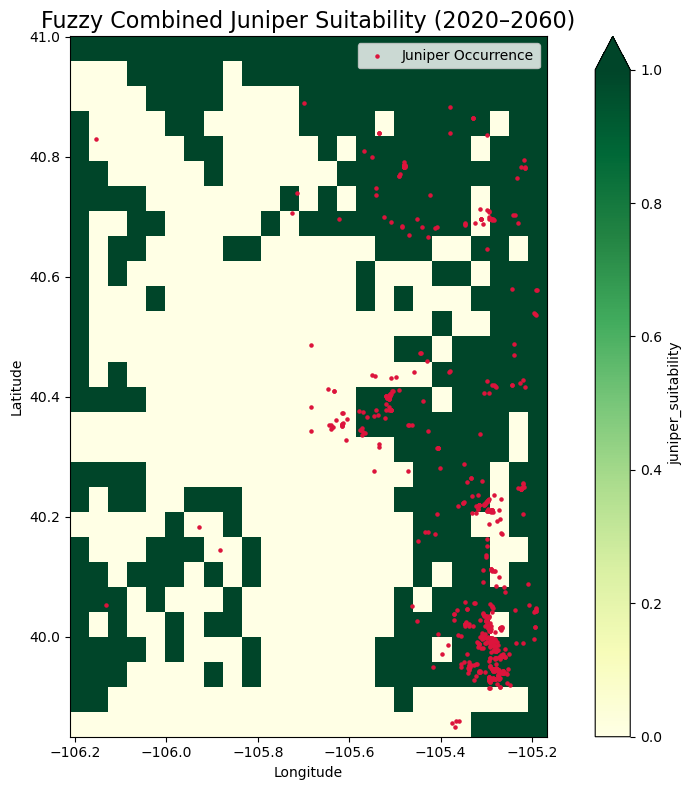

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
im = fuzzy_combined.plot.imshow(
    ax=ax,
    cmap='YlGn',
    vmin=0, vmax=1,
    add_colorbar=True
)

juniper_occur_gdf.plot(ax=ax, color='crimson', markersize=5, label='Juniper Occurrence')

ax.set_title("Fuzzy Combined Juniper Suitability (2020–2060)", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.tight_layout()
plt.show()

In [12]:
print(os.getcwd())
print(os.listdir())

/home/jovyan/data-store/CAST_Species_Test
['.git', '.environ', '.gitignore', 'Colorado_future_fires.csv', 'Combined_Suitability.ipynb', 'Habitat_Suit_Model.ipynb', 'Juniper_Occur.zip', 'LICENSE', 'README.md', 'extracted_county_boundary', 'gbif_data', 'juniper_on_esri_satellite.png', 'level3_ecoregion.zip', 'precip_suitability_future.tif', 'precip_suitability_hist.tif', 'romo_boundary', '.ipynb_checkpoints', 'cache', 'juniper_precip_hist_suitability.png', 'juniper_precip_fut_suitability.png', 'juniper_clay_suitability.png', 'juniper_sand_suitability.png', 'juniper_ph_suitability.png', 'juniper_elev_suitability.png', 'clay_suitability.tif', 'sand_suitability.tif', 'ph_suitability.tif', 'elev_suitability.tif', 'hist_suit.tif', 'fut_suit.tif', 'juniper_suitability_combined_hist.tif', 'juniper_suitability_combined_future.tif', 'juniper_comb_hist_suitability.png', 'juniper_comb_fut_suitability.png', 'juniper_suitability_fuzzy.tif']


In [13]:
shapefile_gdf = gpd.read_file("zip://level3_ecoregion.zip")

# Load CSV (DataFrame)
csv_path = "~/data-store/CAST_Species_Test/Colorado_future_fires.csv"
csv_df = pd.read_csv(csv_path)

In [14]:
shapefile_gdf = gpd.read_file("zip://level3_ecoregion.zip!us_eco_l3_state_boundaries.shp")

In [15]:
print("Shapefile columns:\n", shapefile_gdf.columns)
print(shapefile_gdf.head())

print("\nCSV columns:\n", csv_df.columns)
print(csv_df.head())

Shapefile columns:
 Index(['US_L3CODE', 'US_L3NAME', 'NA_L3CODE', 'NA_L3NAME', 'NA_L2CODE',
       'NA_L2NAME', 'NA_L1CODE', 'NA_L1NAME', 'STATE_NAME', 'EPA_REGION',
       'L3_KEY', 'L2_KEY', 'L1_KEY', 'geometry'],
      dtype='object')
  US_L3CODE    US_L3NAME NA_L3CODE    NA_L3NAME NA_L2CODE  \
0         1  Coast Range     7.1.8  Coast Range       7.1   
1         1  Coast Range     7.1.8  Coast Range       7.1   
2         1  Coast Range     7.1.8  Coast Range       7.1   
3         1  Coast Range     7.1.8  Coast Range       7.1   
4         1  Coast Range     7.1.8  Coast Range       7.1   

                  NA_L2NAME NA_L1CODE                 NA_L1NAME  STATE_NAME  \
0  MARINE WEST COAST FOREST         7  MARINE WEST COAST FOREST  California   
1  MARINE WEST COAST FOREST         7  MARINE WEST COAST FOREST  California   
2  MARINE WEST COAST FOREST         7  MARINE WEST COAST FOREST  California   
3  MARINE WEST COAST FOREST         7  MARINE WEST COAST FOREST  California   


In [16]:
shapefile_gdf['US_L3CODE'] = shapefile_gdf['US_L3CODE'].astype(int)

In [17]:
shapefile_gdf.info()
csv_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1631 entries, 0 to 1630
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   US_L3CODE   1631 non-null   int64   
 1   US_L3NAME   1631 non-null   object  
 2   NA_L3CODE   1631 non-null   object  
 3   NA_L3NAME   1631 non-null   object  
 4   NA_L2CODE   1631 non-null   object  
 5   NA_L2NAME   1631 non-null   object  
 6   NA_L1CODE   1631 non-null   object  
 7   NA_L1NAME   1631 non-null   object  
 8   STATE_NAME  1631 non-null   object  
 9   EPA_REGION  1631 non-null   int32   
 10  L3_KEY      1631 non-null   object  
 11  L2_KEY      1631 non-null   object  
 12  L1_KEY      1631 non-null   object  
 13  geometry    1631 non-null   geometry
dtypes: geometry(1), int32(1), int64(1), object(11)
memory usage: 172.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 16 columns):
 #   Column       Non-Null Count

In [18]:
joined_gdf = shapefile_gdf[['US_L3CODE','geometry']].merge(csv_df[['US_L3CODE', 'year', 'En_NFire', 'En_BurnArea']], on=['US_L3CODE'], how='inner')

In [19]:
joined_gdf

,US_L3CODE,geometry,year,En_NFire,En_BurnArea
0,18,"POLYGON ((-807943.026 2038559.77, -808151.335 ...",2026,3.658214,31990.707473
1,18,"POLYGON ((-807943.026 2038559.77, -808151.335 ...",2025,4.614357,41930.242056
2,18,"POLYGON ((-807943.026 2038559.77, -808151.335 ...",2057,5.976643,57797.622720
3,18,"POLYGON ((-807943.026 2038559.77, -808151.335 ...",2055,4.000143,35862.704709
4,18,"POLYGON ((-807943.026 2038559.77, -808151.335 ...",2056,5.628286,50259.138213
...,...,...,...,...,...
2809,26,"POLYGON ((-490525.377 1508964.652, -490827.631...",2054,11.314500,84541.153906
2810,26,"POLYGON ((-490525.377 1508964.652, -490827.631...",2020,11.069857,84162.249739
2811,26,"POLYGON ((-490525.377 1508964.652, -490827.631...",2029,9.762929,76064.525891
2812,26,"POLYGON ((-490525.377 1508964.652, -490827.631...",2030,12.423571,100688.182841


In [20]:
df = pd.read_csv('Colorado_future_fires.csv', dtype={'year': int})

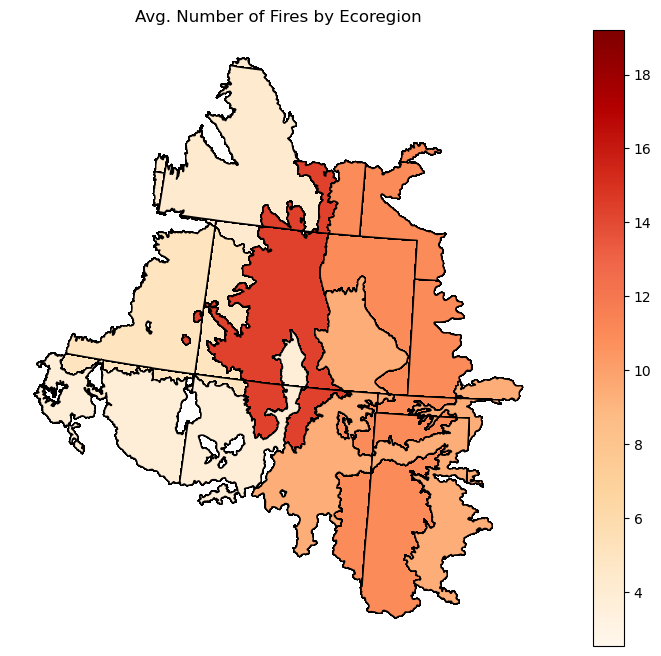

In [21]:
joined_gdf.plot(
    column='En_NFire', 
    cmap='OrRd', 
    legend=True,
    figsize=(12, 8),
    edgecolor='black'
)
plt.title("Avg. Number of Fires by Ecoregion")
plt.axis('off')
plt.show()

In [22]:
forest_gdf = forest_gdf.to_crs(joined_gdf.crs)

In [23]:
roosevelt_clip = gpd.clip(joined_gdf, forest_gdf)

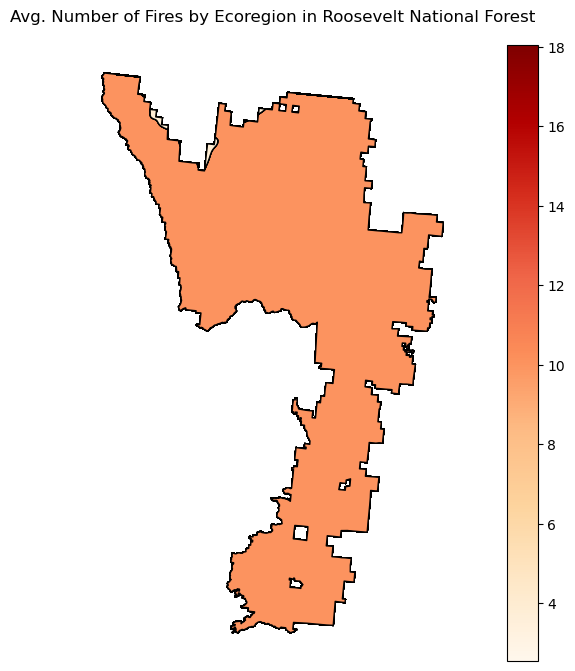

In [24]:
roosevelt_clip.plot(
    column='En_NFire',
    cmap='OrRd',
    legend=True,
    figsize=(12, 8),
    edgecolor='black'
)
plt.title("Avg. Number of Fires by Ecoregion in Roosevelt National Forest")
plt.axis('off')
plt.show()

In [25]:
print(joined_gdf[['US_L3CODE','geometry', 'year', 'En_NFire', 'En_BurnArea']].dropna().head())

   US_L3CODE                                           geometry  year  \
0         18  POLYGON ((-807943.026 2038559.77, -808151.335 ...  2026   
1         18  POLYGON ((-807943.026 2038559.77, -808151.335 ...  2025   
2         18  POLYGON ((-807943.026 2038559.77, -808151.335 ...  2057   
3         18  POLYGON ((-807943.026 2038559.77, -808151.335 ...  2055   
4         18  POLYGON ((-807943.026 2038559.77, -808151.335 ...  2056   

   En_NFire   En_BurnArea  
0  3.658214  31990.707473  
1  4.614357  41930.242056  
2  5.976643  57797.622720  
3  4.000143  35862.704709  
4  5.628286  50259.138213  


In [26]:
print(joined_gdf.columns)

Index(['US_L3CODE', 'geometry', 'year', 'En_NFire', 'En_BurnArea'], dtype='object')


In [27]:
# Path to the zip file
zip_path = os.path.expanduser("~/data-store/data/iplant/home/elemilene01/data_download_habitat_suitability/firedpy_hist.zip")

extract_to = os.path.expanduser("~/data-store/data/iplant/home/elemilene01/data_download_habitat_suitability/firedpy_hist_extracted")

os.makedirs(extract_to, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Extracted all files to: {extract_to}")

Extracted all files to: /home/jovyan/data-store/data/iplant/home/elemilene01/data_download_habitat_suitability/firedpy_hist_extracted


In [28]:
extract_dir = os.path.expanduser("~/data-store/data/iplant/home/elemilene01/data_download_habitat_suitability/firedpy_hist_extracted")

# Walk through the directory and print all files
for root, dirs, files in os.walk(extract_dir):
    print(f"\nDirectory: {root}")
    for file in files:
        print(f"  - {file}")


Directory: /home/jovyan/data-store/data/iplant/home/elemilene01/data_download_habitat_suitability/firedpy_hist_extracted
  - fired_uscan_README.txt
  - fired_uscan_to2021121_events.dbf
  - fired_uscan_to2021121_events.gpkg
  - fired_uscan_to2021121_events.prj
  - fired_uscan_to2021121_events.shp
  - fired_uscan_to2021121_events.shx


In [29]:
fire_gdf = gpd.read_file('/home/jovyan/data-store/data/iplant/home'
'/elemilene01/data_download_habitat_suitability/firedpy_hist_extracted/fired_uscan_to2021121_events.shp')

In [30]:
print(fire_gdf.columns)

Index(['id', 'ig_date', 'ig_day', 'ig_month', 'ig_year', 'last_date',
       'event_dur', 'tot_pix', 'tot_ar_km2', 'fsr_px_dy', 'fsr_km2_dy',
       'mx_grw_px', 'mn_grw_px', 'mu_grw_px', 'mx_grw_km2', 'mn_grw_km2',
       'mu_grw_km2', 'mx_grw_dte', 'lc_code', 'lc_mode', 'lc_name', 'lc_desc',
       'lc_type', 'eco_mode', 'eco_type', 'eco_name', 'ig_utm_x', 'ig_utm_y',
       'tot_perim', 'geometry'],
      dtype='object')


In [31]:
fire_path = '/home/jovyan/data-store/data/iplant/home/elemilene01/data_download_habitat_suitability/firedpy_hist_extracted/fired_uscan_to2021121_events.shp'
fire_gdf = gpd.read_file(fire_path)

In [32]:
from shapely.geometry import box
import numpy as np

minx, miny, maxx, maxy = forest_gdf.total_bounds

# Define cell size
cell_size = 1000  

# Create grid
cols = np.arange(minx, maxx, cell_size)
rows = np.arange(miny, maxy, cell_size)
polygons = [box(x, y, x + cell_size, y + cell_size) for x in cols for y in rows]

grid = gpd.GeoDataFrame({'geometry': polygons}, crs=forest_gdf.crs)

# Clip to forest area
grid = gpd.overlay(grid, forest_gdf, how='intersection')

In [33]:
grid = gpd.overlay(grid, forest_gdf, how='intersection')
grid = grid.reset_index(drop=True) 

fire_gdf = fire_gdf.to_crs(grid.crs)

joined = gpd.sjoin(fire_gdf[['ig_year', 'geometry']], grid, how="inner", predicate="intersects")

fire_years_per_cell = joined.groupby('index_right')['ig_year'].nunique()

# Attach to grid
grid['n_fire_years'] = 0
grid.loc[fire_years_per_cell.index, 'n_fire_years'] = fire_years_per_cell

In [34]:
print(grid['n_fire_years'].value_counts())

n_fire_years
0    3151
1    1398
2     107
3       3
Name: count, dtype: int64


In [35]:
year_range = fire_gdf['ig_year'].max() - fire_gdf['ig_year'].min() + 1
grid['return_period'] = year_range / grid['n_fire_years'].replace(0, np.nan)
grid['fire_probability'] = 1 / grid['return_period']

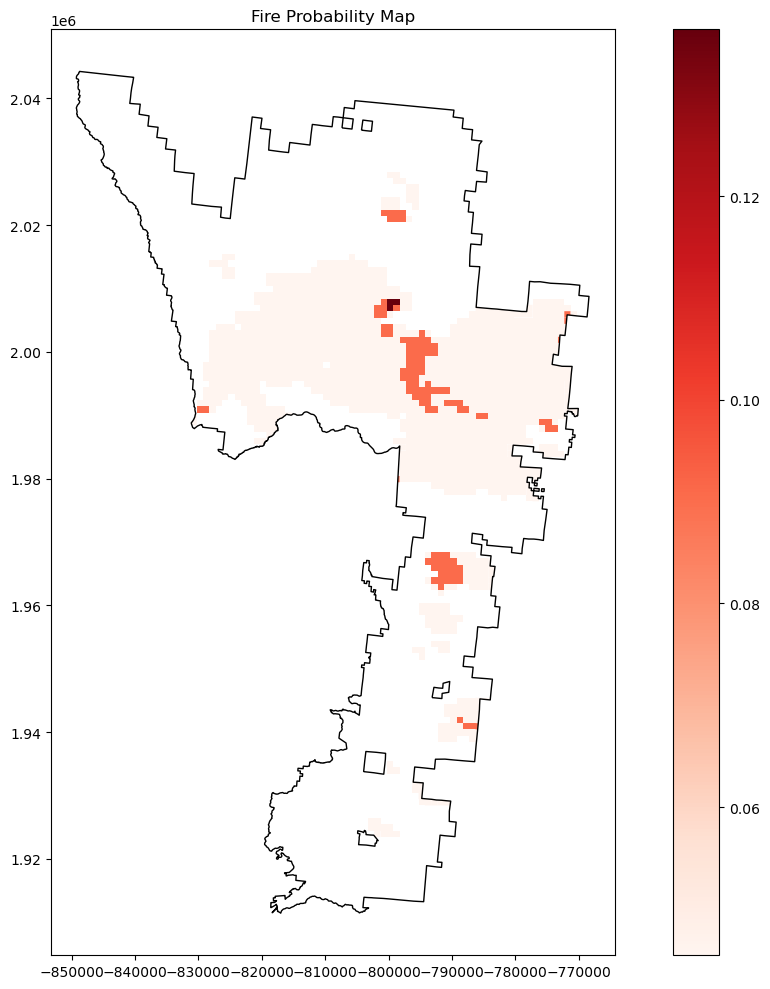

In [38]:
fig, ax = plt.subplots(figsize=(12, 10))
grid.plot(column='fire_probability', cmap='Reds', legend=True, ax=ax, edgecolor='none')

forest_gdf.boundary.plot(ax=ax, color='black', linewidth=1)
ax.set_title("Fire Probability Map")

plt.tight_layout()

plt.savefig("juniper_fire_probability.png", dpi=300, bbox_inches='tight')

plt.show()

In [37]:
#return period for fire data for each year
#pixel for each year
#probability